# Predição dos preços de casas em Melbourn, Austrália

# Introdução

Como estamos vivendo um período economicamente fragilizado com a pandemia do Novo Coronavirus, um pensamento importante surgiu na cabeça de muitos investidores brasileiros, bem como pessoas comuns a procura de uma moradia fixa.

Partindo desse pressuposto, o trabalho a seguir desenvolve um método para a criação de um modelo de predição do preço de casas em Melbourn que, utilizando as devidas modificações, poderá facilmente ser utilizado para a predição de preços de casas aqui no Brasil.

## Funções auxiliares

In [40]:
# Função para imprimir os gráficos de treinamento
def plotHistory(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # Imprime a curva de aprendizado
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # Imprime a curva de acurácia
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

  fig.savefig('/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/' + title)
  plt.show()

## Sobre o Dataset

O dataset escolhido pelo grupo foi retirado de um dos sites mais famosos de Machine Learning, o Kaggle. Nessa seção, iremos estudar um pouco mais sobre o nosso dataset.

In [2]:
# Conectando ao Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Retirando o zip do arquivo
import zipfile

PATH = '/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/price_house_prediction.zip'

# Cria uma stream de leitura ao arquivo do dataset
zp = zipfile.ZipFile(file=PATH, mode='r')
# Extrai os arquivos na pasta atual
zp.extractall('./')
# Fecha a stream
zp.close()

In [4]:
import pandas as pd
import numpy as np

# Importando o dataset
data = pd.read_csv('/content/Melbourne_housing_FULL.csv')
data.head().transpose()

,0,1,2,3,4
Suburb,Abbotsford,Abbotsford,Abbotsford,Abbotsford,Abbotsford
Address,68 Studley St,85 Turner St,25 Bloomburg St,18/659 Victoria St,5 Charles St
Rooms,2,2,2,3,3
Type,h,h,h,u,h
Price,NaN,1.48e+06,1.035e+06,NaN,1.465e+06
Method,SS,S,S,VB,SP
SellerG,Jellis,Biggin,Biggin,Rounds,Biggin
Date,3/09/2016,3/12/2016,4/02/2016,4/02/2016,4/03/2017
Distance,2.5,2.5,2.5,2.5,2.5
Postcode,3067,3067,3067,3067,3067


Logo de cara podemos perceber que o dataset possui muitas colunas. Bem como a maioria delas possuem dados Categóricos, tais como o "Adress", "Type", "Method", "CouncilArea", entre outros.

Além disso, é possível observar que existem dados numéricos muito discrepantes entre si, como é o caso entre "Rooms" e "Price" ou "LandSize" e "Car".

Para piorar ainda mais a situação, logo nas primeiras linhas do dataset já podemos perceber que muitos dos valores, provavelmente importantes, estão faltando, como é o caso do "BuildingArea" e "YearBuilt".

Ademais, a fim de conhecermos um pouco mais o nosso dataset vamos explorar algumas funcionalidades que a biblioteca do Pandas e do Numpy nos oferece.

In [5]:
# Analisando estatísticas do nosso Dataset
data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


###Analisando a Correlação de Pearson e de Spearman

A Correlação de Pearson é uma métrica muito utilizada para saber o quanto que uma variável numérica interfere ou é inteferida por outra variável de forma linear. Equanto que a correlação de Spearman é utilizada para casos não lineares.

In [6]:
# Correlação de Pearson
pearson = data.corr(method='pearson')
# Correlação de Spearman
spearman = data.corr(method='spearman')

In [7]:
import numpy as np
# Criando a máscaras para os Heatmapa da correlações
mask_pearson = np.triu(np.ones_like(pearson, dtype=bool))
mask_spearman = np.triu(np.ones_like(spearman, dtype=bool))

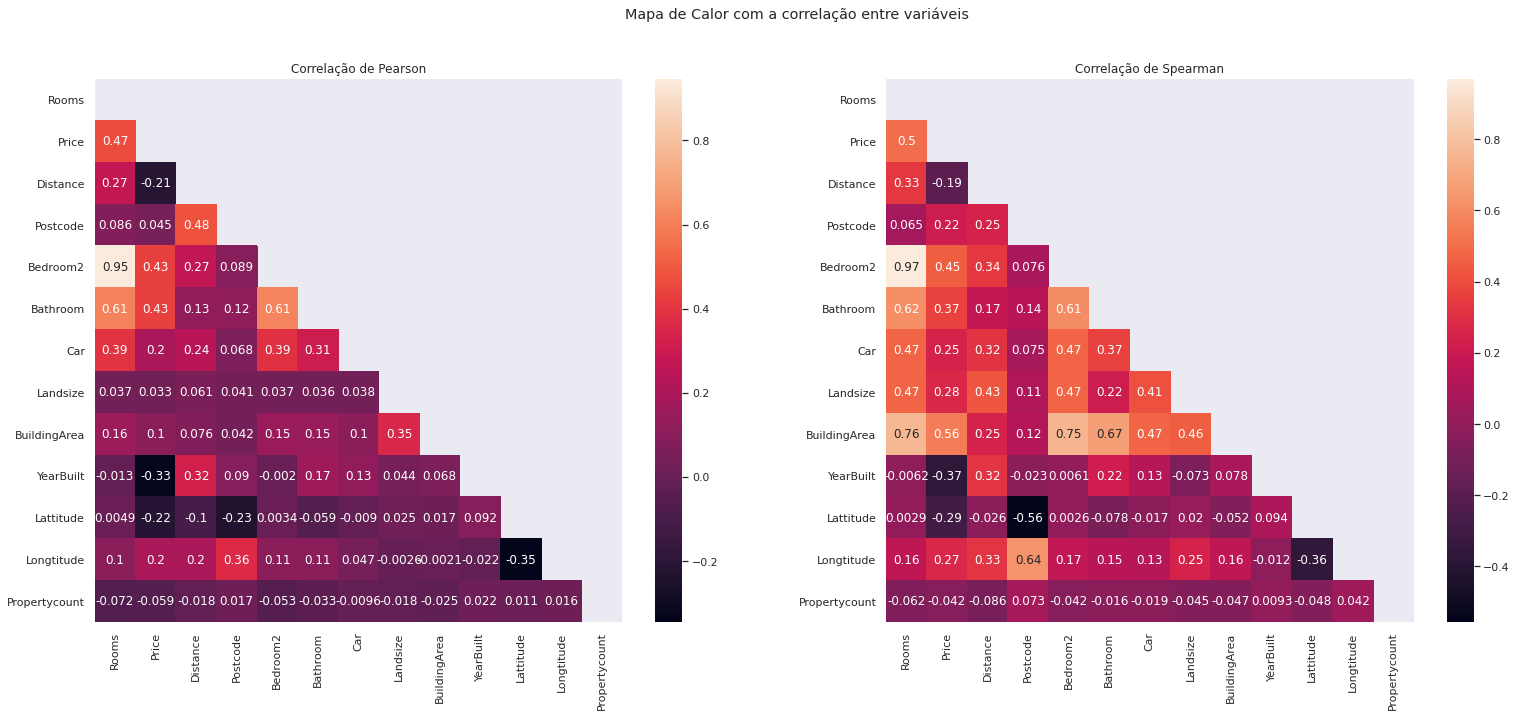

In [8]:
#Imprimindo o heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2,figsize=(26,10))
sns.heatmap(data=pearson, annot=True, mask=mask_pearson, ax=ax[0])
ax[0].set_title("Correlação de Pearson")
sns.heatmap(data=spearman, annot=True, mask=mask_spearman, ax=ax[1])
ax[1].set_title("Correlação de Spearman")
fig.suptitle('Mapa de Calor com a correlação entre variáveis')
fig.show()

Através da análise do mapa de calor, podemos perceber que os preços das casas possuem 43% de correlação com a quantidade de banheiros e quartos na casa. Bem como possui uma forte correlação não linear com a área construída.

## Pré-processamento do dataset

In [9]:
# Relembrando o nosso dataset
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [10]:
#Copiando o dataset
data_cp = data.copy()

### Tratamento de Valores Faltantes

É imprescindível que os dados fornecidos ao nosso modelo não sejam faltantes pois, caso isso aconteça, é possível haver erros tanto no treinamento do modelo quanto, a nível de compilação, quanto no aprendizado do mesmo.

Para tanto, faz-se necessário adotarmos técnicas para lidar com esses dados faltantes. Para esse notebook, vamos utilizar duas delas:

*   Deletar os valores vazios;
*   Preencher os valores vazios com suas respectivas médias;



In [11]:
#Procurando por valores vazios
data_cp.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [12]:
data_cp.loc[data_cp["Bedroom2"].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
15,Abbotsford,217 Langridge St,3,h,1000000.0,S,Jellis,8/10/2016,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
16,Abbotsford,18a Mollison St,2,t,745000.0,S,Jellis,8/10/2016,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
19,Abbotsford,403/609 Victoria St,2,u,542000.0,S,Dingle,8/10/2016,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
21,Abbotsford,25/84 Trenerry Cr,2,u,760000.0,SP,Biggin,10/12/2016,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
22,Abbotsford,106/119 Turner St,1,u,481000.0,SP,Purplebricks,10/12/2016,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34838,Williamstown,11/81 Melbourne Rd,2,u,450000.0,SP,Raine,24/02/2018,6.8,3016.0,NaN,NaN,NaN,NaN,NaN,NaN,Hobsons Bay City Council,NaN,NaN,Western Metropolitan,6380.0
34839,Williamstown,24/18 Station Rd,2,u,475000.0,SP,Greg,24/02/2018,6.8,3016.0,NaN,NaN,NaN,NaN,NaN,NaN,Hobsons Bay City Council,NaN,NaN,Western Metropolitan,6380.0
34840,Williamstown,3/2 Thompson St,2,u,520000.0,VB,Raine,24/02/2018,6.8,3016.0,NaN,NaN,NaN,NaN,NaN,NaN,Hobsons Bay City Council,NaN,NaN,Western Metropolitan,6380.0
34844,Windsor,4/16 Lewisham Rd,1,u,440000.0,SP,Biggin,24/02/2018,4.6,3181.0,NaN,NaN,NaN,NaN,NaN,NaN,Port Phillip City Council,NaN,NaN,Southern Metropolitan,4380.0


In [13]:
# Casa mais barata sem informações sobre quartos
data_cp["Price"].loc[data_cp["Bedroom2"].isna()].min()

112000.0

In [14]:
# Casa média sem informações sobre quartos
data_cp["Price"].loc[data_cp["Bedroom2"].isna()].mean()

920983.1047973917

In [15]:
# Casa mais cara sem informações sobre quartos
data_cp["Price"].loc[data_cp["Bedroom2"].isna()].max()

7000000.0

Após uma análise dos valores das casas em relação ao número de quartos e banheiros que não possuem informações. Pode-se concluir que tais preços são muito diferentes e valores bem altos, ou seja, não vale a pena utilizar a média para representar tais valores. Basta analisarmos que existem casas que custam U\$7.000.000,00 e outras que custam U\$112.000,00.

Além disso, podemos concluir também, analisando os dados faltantes, que um número considerável de casas do nosso dataset não possuem informações sobre "Buildingarea" ou "Landsize". Portanto, precisamos nos atentar se, apagando os outros dados faltantes, esse número irá diminuir muito ou pouco.

In [16]:
# Apagando as linhas cusjas casas não possuem informação sobre os quartos e banheiros
data_cp = data_cp.dropna(subset=["Price", "Bathroom", "Bedroom2", "CouncilArea", "Distance", "Postcode", "YearBuilt", "Lattitude", "Longtitude", "Regionname"])
data_cp.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
11,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.8024,144.9993,Northern Metropolitan,4019.0
14,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,-37.8060,144.9954,Northern Metropolitan,4019.0


In [17]:
data_cp.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car               195
Landsize         1462
BuildingArea     1834
YearBuilt           0
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

Como o número de dados faltantes em "Cars", "BuildingArea" e "Landsize" diminuiu bastante, podemos utilizar a técnica de preenchimento com o valor da média. 

Antes de dividir o nosso dataset entre previsores e classes (ou X e Y) precisamos lidar com as datas da coluna "Date", que representam o dia em que a casa foi vendida.

In [18]:
# Visualizando os valores
data_cp['Date'].head()

2     4/02/2016
4     4/03/2017
6     4/06/2016
11    7/05/2016
14    8/10/2016
Name: Date, dtype: object

In [19]:
data_cp['Date'] = pd.to_datetime(data_cp['Date'],
                                 format='%d/%m/%Y',
                                 errors='coerce')
# Visualizando o resultado
data_cp['Date'].head()

2    2016-02-04
4    2017-03-04
6    2016-06-04
11   2016-05-07
14   2016-10-08
Name: Date, dtype: datetime64[ns]

Perceba que antes o nosso tipo de dado era "object" e agora temos um tipo de dado próprio do pandas chamado de "datetime64[ns]"

Agora sim, podemos separar os nossos previsores das nossas classes - Ou o nosso X do nosso Y, já que se trata de uma Regressão.

In [20]:
# Separando os previsores das classes
prev = data_cp.drop(columns=["Suburb", "Address", "Postcode", "Price", "Propertycount"]).values
classe = data_cp["Price"].values.reshape(-1,1)


Como "PropertyCount" mostrou uma correlação muito baixa, tanto linear quanto não linear, ao preço das casas, não vamos utilizá-lo para o treinamento do nosso modelo.

Além disso, perceba que podemos determinar o "Suburb", "Address" e "Postcode" de uma casa através da sua latitude e longitude. Por causa disso, não iremos considerar esses atributos.

In [21]:
# Inserindo as médias nos valores faltantes
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(prev[:, 8:11])
prev[:, 8:11] = imputer.transform(prev[:,8:11])

In [22]:
# Verificando se existe algum valor nulo
pd.isnull(prev).sum()

0

Acima, fizemos o preenchimento dos valores faltantes e a confirmação que não existe nenhuma tipo de dado faltante. 

A partir de agora, podemos proceguir com o nosso processamento do dataset.

### Transformando variáveis nominais em numéricas

Outro tratamento importante que precisamos fazer é substituir as variáveis do tipo nominais por variáveis numéricas. Isso porque uma rede neural utiliza modelos matemáticos complexos para o seu treinamento, tornando impossível realizar operações como soma em subtração em variáveis como "Abbotsford".

Para isso, vamos utilizar a biblioteca `sklearn` para transformar esse tipo de variável em números.

In [23]:
from sklearn.preprocessing import LabelEncoder

labelencoder_previsores = LabelEncoder()
prev[:, 1] = labelencoder_previsores.fit_transform(prev[:, 1])  #Type
prev[:, 2] = labelencoder_previsores.fit_transform(prev[:, 2])  #Method
prev[:, 3] = labelencoder_previsores.fit_transform(prev[:, 3])  #SellerG
prev[:, 4] = labelencoder_previsores.fit_transform(prev[:, 4])  #Date
prev[:, 12] = labelencoder_previsores.fit_transform(prev[:, 12]) #CouncilArea
prev[:, 15] = labelencoder_previsores.fit_transform(prev[:, 15]) #Regionname

In [24]:
# Visualizando os tramentos nos previsores
pd.DataFrame(prev, columns=['Rooms', 'Type', 'Method',
                            'SellerG', 'Date', 'Distance', 'Bedroom2',
                            'Bathroom', 'Car', 'Landsize', 'BuildingArea',
                            'YearBuilt', 'CouncilArea', 'Lattitude','Longtitude',
                            'Regionname']).head()

,Rooms,Type,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
0,2,0,1,24,0,2.5,2,1,0,156,79,1900,31,-37.8079,144.993,2
1,3,0,3,24,32,2.5,3,2,0,134,150,1900,31,-37.8093,144.994,2
2,4,0,4,161,7,2.5,3,1,2,120,142,2014,31,-37.8072,144.994,2
3,3,0,1,161,3,2.5,4,2,0,245,210,1910,31,-37.8024,144.999,2
4,2,0,1,161,22,2.5,2,1,2,256,107,1890,31,-37.806,144.995,2


### Categorização das variáveis Nominais

Nesse dataset existem algumas colunas que possuem variáveis do tipo categórica, tais como "Method", "SellerG", "CouncilArea" e "Regionname", que, após o LabelEconder, foram transformados em variáveis numéricas onde o valor de 0 não vale nem mais e nem menos que o 2, uma vez que estamos fazendo apenas uma "tradução" de uma variável nominal para numérica.

 Para que o nosso modelo compreenda isso, temos que realizar uma transformação chamada de `OneHotEncoder`. Onde cada valor de um atributo vai se transforma em um novo atributo, tal que, caso o método seja o valor "0", será criada um novo atributo com o nome de "Method 0" e o mesmo receberá o valor de um, enquanto que as outras colunas geradas receberão o valor de 0.

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Transformando "Method", "SellerG", "CouncilArea" e "Regionname"
onehotencorder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [2,3,12,15])], remainder='passthrough')
prev = onehotencorder.fit_transform(prev).toarray()

### Normalização de Atributos

Como existem atributos com grandezas totalmente distintas, é uma boa prática escalonarmos os valores dos nossos atributos. Existem duas principais formas de fazer isso, a primeiro é a padronização, onde o valor de cada atributo é subtraído do valor médio e dividido pelo valor médio. Dessa forma, a padronização pode receber qualquer valor próximo do 0, negativo ou positivo. A segunda forma é a normalização, que subtrai o valor de um atributo pelo valor mínimo e divide pela subtração do máximo e mínimo. Tal operação é mais interessante para nós, uma vez que não irá interferir nos valores dos atributos gerados pelo `OneHotEncoder`.

In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_X = MinMaxScaler()
prev = scaler_X.fit_transform(prev)

### Separação da Base de Dados

Vamos agora dividir a nossa base de dados em validação, teste e treinamento. Para isso, vamos utilizar a função do `sklearn` que irá nos garantir que a base de dados ficará com a mesma proporção de acordo com um atributo que nós iremos definir. Para esse caso específico, vamos escolher "Rooms", que segundo o mapa de calor, possui a maior correlação com o "Price".

In [27]:
from sklearn.model_selection import train_test_split

#Base de treino e teste+valid
train_x, test_valid_x, train_y, test_valid_y = train_test_split(prev, classe, test_size=0.1, random_state=0, stratify=prev[:, 0])

#Base de teste e validação
test_x, valid_x, test_y, valid_y = train_test_split(test_valid_x, test_valid_y, test_size=0.5, random_state=0, stratify=test_valid_x[:, 0])

# Criando o modelo

## Criação do primeiro modelo

A fim de resolver esse nosso problema, iremos utilizar um modelo de Machine Learning conhecido como MLP, ou MultiLayers Perceptron, que tenta reproduzir as conexões nervosas de um cérebro humano por meio de uma modelo matemático e um sistema complexos de conexões densas entre neurônios de camadas subjacentes,

Para explorar a complexidade desse nosso problema, vamos criar três modelos de MLP de formas totalmente distintas, tentando aumentar cada vez mais a acurácia do modelo e diminuir a sua perda.

Dessa forma, vamos começar com um modelo super simples com apenas uma camada oculta e 20 neurônios.

In [28]:
import tensorflow as tf
model_first = tf.keras.models.Sequential()

Como se trata de um problema de regressão, nossa rede neural precisa ter apenas um neurônio na camada de saída, uma vez que o valor que estiver nesse neurônio corresponde a predição do preço da casa.

In [29]:
from tensorflow.keras.layers import Dense

model_first.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
model_first.add(Dense(1, activation='relu'))

## Compilando o primeiro modelo

Como primeiro otimizador, iremos utilizar a Descida do Gradiente Estocástico, ou SGD como é mais conhecido. Nele, iremos usar a taxa de aprendizagem de 0.01 e um momento de 0.9 para acelerar a aprendizagem e diminuir as chances da nossa rede cair em uma "vala" onde o valor do gradiente é mínimo apenas localmente (a ideia é buscarmos o valor mínimo global).

Como métricas desse nosso modelo estaremos utilizando a função perda como Média do Erro Absolute em Porcentagem (MAPE) e a acurácia será o Erro Médio Absoluto (MAE). O que queremos é que ambos os valores sejam os menores possíveis.

In [30]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model_first.compile(loss='mape', optimizer=opt, metrics=['mae'])

## Treinando o primeiro modelo

Inicialmente, vamos treinar o nosso modelo em 200 épocas, utilizando os nossos dados de treino separados na seção anterior. Além disso, vamos definir o batch_size como o tamanho do próprio `train_x`, ou seja, Batch Gradient Decent.

In [34]:
history_tiny = model_first.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=200, verbose=1, batch_size=train_x.shape[0])

Epoch 1/200
1/1 [==============================] - 0s 76ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 2/200
1/1 [==============================] - 0s 35ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 4/200
1/1 [==============================] - 0s 36ms/step - loss: 100.0000 - mae: 1080161.3750 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 5/200
1/1 [==============================] - 0s 40ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 6/200
1/1 [==============================] - 0s 35ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - val_mae: 1095906.1250
Epoch 7/200
1/1 [==============================] - 0s 36ms/step - loss: 100.0000 - mae: 1080161.2500 - val_loss: 100.0000 - 

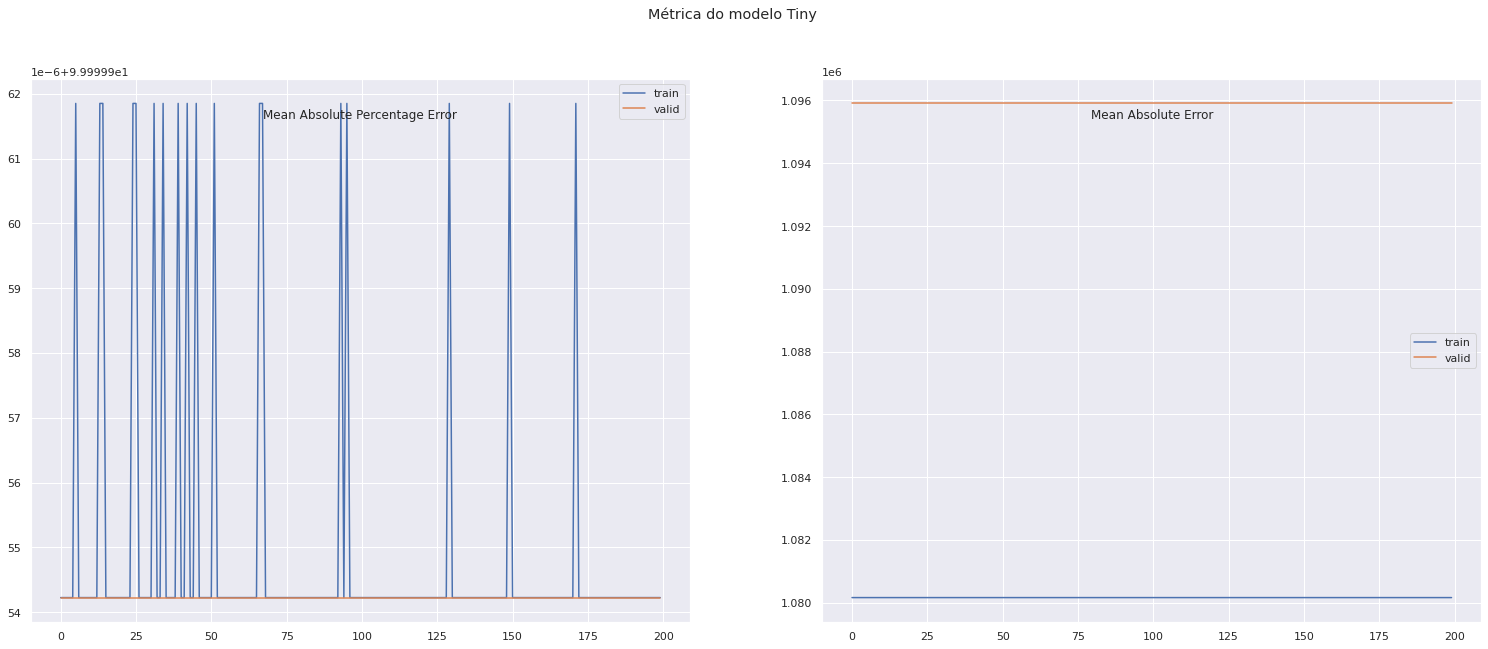

In [41]:
title_tiny = 'Métrica do modelo Tiny'
# Imprime os gráficos do MAPE e MAE (Loss e Metric, respectivamente)
plotHistory(history_tiny, title_tiny)

Podemos perceber que o erro médio absoluto, bem como o Loss, encontram-se bem longe do esperado. Na verdade, o modelo que criamos para resolver o problema é extremamente simples se comparado à complexidade do problema e foi, basicamente, massacrado.

 Para conseguirmos diminuir o loss e melhorarmos o erro médio absoluto, isto é, diminuir o Bias do nosso modelo, vamos aumentar o número de neurônios nas camadas ocultas, bem como o número de camadas ocultas.

 Além disso, iremos adicionar uma técnica de regularização da rede neural chamada de Dropout, que resulta na melhora da generalização do modelo, por meio do "desligamento" de parte dos nossos neurônios.

Por fim, como vamos aumentar a complexidade do nosso modelo, vamos utilizar a técnica de mini-batch, através do parâmetro batch_size = 32, para acelerar o processo de treinamento.

In [42]:
# Verificando o shape da nossa base de treinamento
train_x.shape

(10867, 336)

## Aumentando a complexidade do modelo

Como vamos aumentar a complexidade do nosso modelo, é possível que o mesmo sofra um fenômeno chamado de "Overfitting", que nada mais é que um modelo "bom demais" para a complexidade do problema, que acaba por "decorar" as informações contidas nos dados de treinamento ao invés de "aprender".

Para evitarmos esse tipo de problemas podemos utilizar uma técnica chamada de Dropout. O Dropout permite que uma parte dos neurônios de uma camada oculta parem de funcionar, compensando os valores das entradas nos demais neurônios de acordo com a porcentagem de neurônios que escolhermos para "desativar". Tal fenômeno acaba por deixar a rede "menos inteligente" e, portanto, ajuda na melhor generalização do modelo.

Um valor muito defendido na literatura para essa técnica é o de 20%, portanto, é exatamente esse valor que iremos utilizar no nosso modelo.

In [43]:
model_large = tf.keras.models.Sequential()

model_large.add(Dense(512, input_dim=train_x.shape[1], activation='relu', kernel_initializer='he_uniform')),
model_large.add(tf.keras.layers.Dropout(0.2))
model_large.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_large.add(tf.keras.layers.Dropout(0.2))
model_large.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_large.add(tf.keras.layers.Dropout(0.2))
model_large.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_large.add(tf.keras.layers.Dropout(0.2))
model_large.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_large.add(tf.keras.layers.Dropout(0.2))
model_large.add(Dense(1, activation='relu'))

In [44]:
model_large.compile(loss='mape', optimizer='adam', metrics=['mae'])

In [45]:
model_large.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               172544    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

Para esse caso, estamos utilizando uma rede neural com 5 camadas ocultas e 512 neurônios em cada camada. Para acelerar o processo de treinamento, iremos utilizar de uma técnica chamada de "Minibatch Gradient Descent" que acelera o processo de treinamento mas, dependendo do tamanho do batch, causará ruídos nos valores da loss function e MAE. 

Portanto, para esse modelo e o próximo, estaremos utilizando um valor bastante defendido na literatura e entre pesquisadores de 32 amostras.

In [46]:
history_large = model_large.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=100, verbose=1, batch_size=32)

Epoch 1/100
340/340 [==============================] - 2s 3ms/step - loss: 57.2325 - mae: 662603.3394 - val_loss: 19.8806 - val_mae: 266057.7188
Epoch 2/100
340/340 [==============================] - 1s 3ms/step - loss: 20.2439 - mae: 249445.8344 - val_loss: 18.5063 - val_mae: 245395.1562
Epoch 3/100
340/340 [==============================] - 1s 3ms/step - loss: 18.9715 - mae: 231611.0976 - val_loss: 17.3091 - val_mae: 217761.4531
Epoch 4/100
340/340 [==============================] - 1s 3ms/step - loss: 18.0293 - mae: 223187.9065 - val_loss: 17.2226 - val_mae: 223963.6562
Epoch 5/100
340/340 [==============================] - 1s 3ms/step - loss: 17.9435 - mae: 218074.3188 - val_loss: 17.7514 - val_mae: 209424.6875
Epoch 6/100
340/340 [==============================] - 1s 3ms/step - loss: 17.7519 - mae: 213135.8724 - val_loss: 17.3982 - val_mae: 208596.7500
Epoch 7/100
340/340 [==============================] - 1s 3ms/step - loss: 17.4019 - mae: 207416.2811 - val_loss: 17.0988 - val_ma

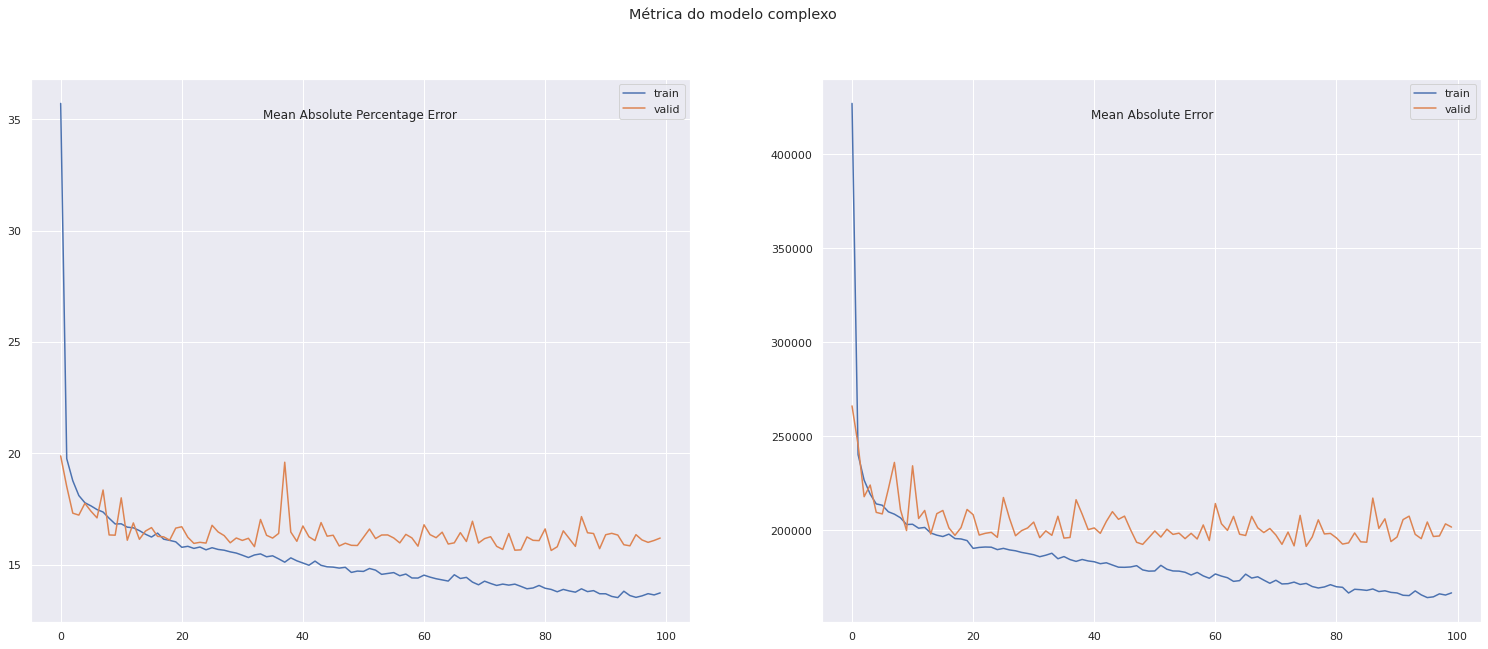

In [47]:
title_large = 'Métricas do modelo complexo'
plotHistory(history_large, title_large)

Mesmo utilizando todas essas técnicas para melhorar a nossa rede neural, não podemos concluir que esse é o melhor modelo de todos para esse problema.

Tivemos sim um ganho considerável ao aumentar a nossa rede neural, mas será que esse é o máximo que podemos alcançar? Para descobrir isso, teremos que ficar criando várias rede neurais manualmente até definir qual a melhor? Bem, no próximo tópico iremos discutir mais sobre essas perguntas.

# Fine Tuning

Ok, agora que constatamos que o modelo está indo por um caminho razoavelmente promissor, vamos utilizar todas as cartas que temos na manga para realizar a construção do melhor modelo possível. Para isso, vamos utilizar algumas técnicas de melhoramento do modelo, conhecidas como "Hyperparameter Tuning" e "Batch normalization".

O **Hyperparameter Tuning** consiste em variarmos os valores dos hiperparâmetros dos modelos, sendo o hiperparametro mais importante a taxa de aprendizagem, logo após o momento, número de units das camadas ocultas e o tamanho do mini-batch, e por fim temos as configurações dos otimizadores, o número de camadas o decaimento da taxa de aprendizagem.

Considerando que o último modelo apresentou um ótimo rendimento, vamo utiliza-lo como base da nossa MLP e checarmos qual a melhor taxa de aprendizagem para o nosso modelo, bem como se é necessário alterarmos o número de neurônios das nossas camadas ocultas e/ou alterarmos o número de camadas ocultas.

Já o **Batch Normalization** consiste na normalização do valores da camada de entrada por meio de re-centramento e redimensionamento, o que resulta em um treinamento mais rápido, se medirmos esse tempo em número de épocas. Tal técnica nos permite a utilização de taxas de aprendizagem maiores e um menor cuidado com relação à inicialização dos pesos de cada camada.

### Definindo função para construção do modelo

In [48]:
def model_builder(hp):
  # Inicializa um modelo de Regressão simples
  model = tf.keras.Sequential()
  
  # Cria um modelo com número de layers entre 5 e 10
  for i in range(hp.Int('num_layers', 5, 10)):

    # Tuna o número de units na camada densa
    hp_int = hp.Int('units_' + str(i), min_value = 128, max_value = 768, step = 128)
    # Escolhe o melhor valor entre 128-768
    model.add(tf.keras.layers.Dense(units=hp_int, kernel_initializer='he_uniform'))
    # Adiciona o batch Normalization antes da função de ativação
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.nn.relu))
    # Adiciona o Dropout
    model.add(tf.keras.layers.Dropout(0.2))
  # Camada de saída
  model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

  # Tuna a taxa de aprendizagem do otimizador escolhendo
  # o melhor valor entre 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

  # Configura o otimizador, loss, e métricas para monitorar.
  model.compile(optimizer=opt, loss='mape', metrics=['mae'])

  return model

#### Fazendo o download da biblioteca do KerasTuner 

In [49]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=abe801ece4c72251c883bf5f73284c45ef0472ebc3541aba045a33e0515b3a48
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=4da33275324ce2767a432d27ed35b0b8a316b2b54ea1804a42cedfbdf04932b3
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Iniciando o Tuner e performando o Hypertuning

Existem três principais formas de se tunar uma MLP. A primeira e mais simples é a RandomSearch, que fará todas as escolhas dos hiperparametros de forma automática e, após cada treinamento, irá comparar com os dados do treinamento anterior e ver qual dos conjuntos é melhor.

Entretanto, o RandomSearch tem o problema de fazer o treinamento até o fim, de acordo com as épocas escolhidas, tornando o treinamento extremamente lento e desperdiçando poder computacional com escolhas aleatórias não muito boas. Para resolver esse problema, foi criado o Hyperband, que consegue parar o treinamento de acordo com o número de iterações que você definir para que um conjunto de hiperparametros ruim não seja treinado por todas as épocas.

Porém continuamos com um problema: o fato de que essas escolhas dos hiperparametros são aleatórias. Isso resulta em escolhas piores que as anteriores, eventualmente, tornando o processo muito longo para a obtenção de um ótimo conjunto de hiperparâmetros. Para sanar esse problema, foi desenvolvido a otimização bayesiana, ou "Bayesian Optimization", que escolhe o set de hiperparametros de acordo com os resultados do set anterior. Obviamente, é esta técnica que iremos utilizar.

In [50]:
from kerastuner.tuners import BayesianOptimization

In [51]:
# Diretório de armazenamento do tuner
LOG_DIR = '/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/Tuner_Results'

In [52]:
tuner = BayesianOptimization(model_builder, 
                             objective='val_mae',
                             max_trials=100,  # Número de configurações para teste
                             executions_per_trial=1,  # Número de tentativas por modelo
                             directory=LOG_DIR,
                             project_name="price_house_tuner_best"
                             )

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/Tuner_Results/price_house_tuner_best/oracle.json
INFO:tensorflow:Reloading Tuner from /content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/Tuner_Results/price_house_tuner_best/tuner0.json


Se olharmos para o nosso último modelo, em 50 épocas o mesmo já estava bom. Entretanto, como ficaremos alternando a taxa de aprendizagem, pode ser que o nosso modelo precise de mais tempo para o treinamento. Dessa forma, vamos estabeler um valor máximo de épocas em 100 e estabelecer que, caso o treinamento não esteja surtindo efeito, isto é, caso o treinamento não minimize o `val_loss` em pelo menos 0.01% por 5 épocas e o `val_loss` seja menor que 20%, o treinamento será finalizado, armazenando os pesos da melhor época.

Para isso, precisamos definir um callback que consiga executar essa pausa cedo. Para a nossa alegria, o Keras nos fornece esse callback, chamado de `EarlyStopping`. Nele temos que passar como parâmetros a métrica que queremos monitorar, o valor mínimo de variação, a paciência do nosso callback e o valor base.

In [53]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0.01,
                                              patience=5,
                                              baseline=20
                                              )

In [197]:
# Executando a pesquisa de hyperparametro
tuner.search(train_x,
             train_y,
             epochs=100,
             verbose=1,
             batch_size=32,
             validation_data = (valid_x, valid_y),
             callbacks = [stop_early])

Trial 55 Complete [00h 01m 00s]
val_mae: 566293.8125

Best val_mae So Far: 534737.8125
Total elapsed time: 00h 58m 12s
INFO:tensorflow:Oracle triggered exit


Ok, agora sim alcançamos o estado da arte quando falamos de Multi Layers Peceptrons, ou MLP. 

O nosso modelo está sendo criado de forma totalmente automatizada. Os principais hiperparametros estão sendo definidos da melhor forma possível. Porém, tudo isso tem um custo... Que custo é esse? Justamente o custo computacional, isto é, para fazermos esse processo, precisamos esperar por horas, às vezes até dias, dependendo da complexidade do nosso modelo. Por isso é importante tentarmos criar um modelo complexo de forma manual, como fizemos na seção anterior, para que tenhamos o míunimo de noção do que é um bom modelo.

### Extraindo informações sobre o modelo pelo Tuner

No código abaixo, temos informações sobre os hiperparametros dos melhores modelos que conseguimos.

In [54]:
# Resumo do hyperparameter tuning
tuner.results_summary()

Results summary
Results in /content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/Tuner_Results/price_house_tuner_best
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
num_layers: 7
units_0: 640
units_1: 640
units_2: 640
units_3: 640
units_4: 640
learning_rate: 0.01
units_5: 768
units_6: 768
units_7: 768
units_8: 768
units_9: 768
Score: 534737.8125
Trial summary
Hyperparameters:
num_layers: 7
units_0: 640
units_1: 640
units_2: 640
units_3: 640
units_4: 640
learning_rate: 0.01
units_5: 768
units_6: 768
units_7: 768
units_8: 768
units_9: 768
Score: 539821.8125
Trial summary
Hyperparameters:
num_layers: 7
units_0: 640
units_1: 640
units_2: 640
units_3: 640
units_4: 640
learning_rate: 0.01
units_5: 768
units_6: 768
units_7: 768
units_8: 768
units_9: 768
Score: 542090.0625
Trial summary
Hyperparameters:
num_layers: 7
units_0: 640
units_1: 640
units_2: 640
units_3: 640
units_4: 640
learning_rate: 0.01
units_5: 768
units_6: 768
units_7: 768


E abaixo, temos o melhor dos melhores. Aquele que iremos utilizar para saber se tivemos ganhos consideráveis com essa técnica.

In [55]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.01,
 'num_layers': 7,
 'units_0': 640,
 'units_1': 640,
 'units_2': 640,
 'units_3': 640,
 'units_4': 640,
 'units_5': 768,
 'units_6': 768,
 'units_7': 768,
 'units_8': 768,
 'units_9': 768}

## Utilizando o modelo com os melhores hiperparametros

Agora que descobirmos os melhores hiperparametros para o nosso modelo, vamos resgatar essas informações através do `tuner` que utilizamos e construir o nosso modelo.

Logo em seguida, vamos treinar esses nossos modelos e submetê-lo a alguns testes com as nossas variáveis de teste (`test_x` e `test_y`).

### Construindo o modelo

In [56]:
# Resgatando o melhor hiperparametro
best_hps = tuner.get_best_hyperparameters()[0]
# Criando o nosso modelo
model_tuned = tuner.hypermodel.build(best_hps)

### Treinando o modelo

In [57]:
history_tuned = model_tuned.fit(train_x, train_y, epochs = 100, validation_data = (valid_x, valid_y),
          batch_size=32, verbose=1)

Epoch 1/100
340/340 [==============================] - 4s 8ms/step - loss: 99.5935 - mae: 1087895.0444 - val_loss: 87.5878 - val_mae: 1021361.6875
Epoch 2/100
340/340 [==============================] - 2s 7ms/step - loss: 93.5981 - mae: 1046513.1076 - val_loss: 79.7817 - val_mae: 972077.0625
Epoch 3/100
340/340 [==============================] - 2s 7ms/step - loss: 80.1967 - mae: 944721.0942 - val_loss: 69.0147 - val_mae: 880960.1250
Epoch 4/100
340/340 [==============================] - 2s 7ms/step - loss: 63.7470 - mae: 840701.7854 - val_loss: 52.3361 - val_mae: 746587.0000
Epoch 5/100
340/340 [==============================] - 2s 7ms/step - loss: 48.7209 - mae: 690607.4377 - val_loss: 40.4095 - val_mae: 606531.6250
Epoch 6/100
340/340 [==============================] - 2s 7ms/step - loss: 37.8718 - mae: 571474.7100 - val_loss: 29.4615 - val_mae: 477608.1562
Epoch 7/100
340/340 [==============================] - 3s 7ms/step - loss: 30.6112 - mae: 471301.2469 - val_loss: 23.7421 - val

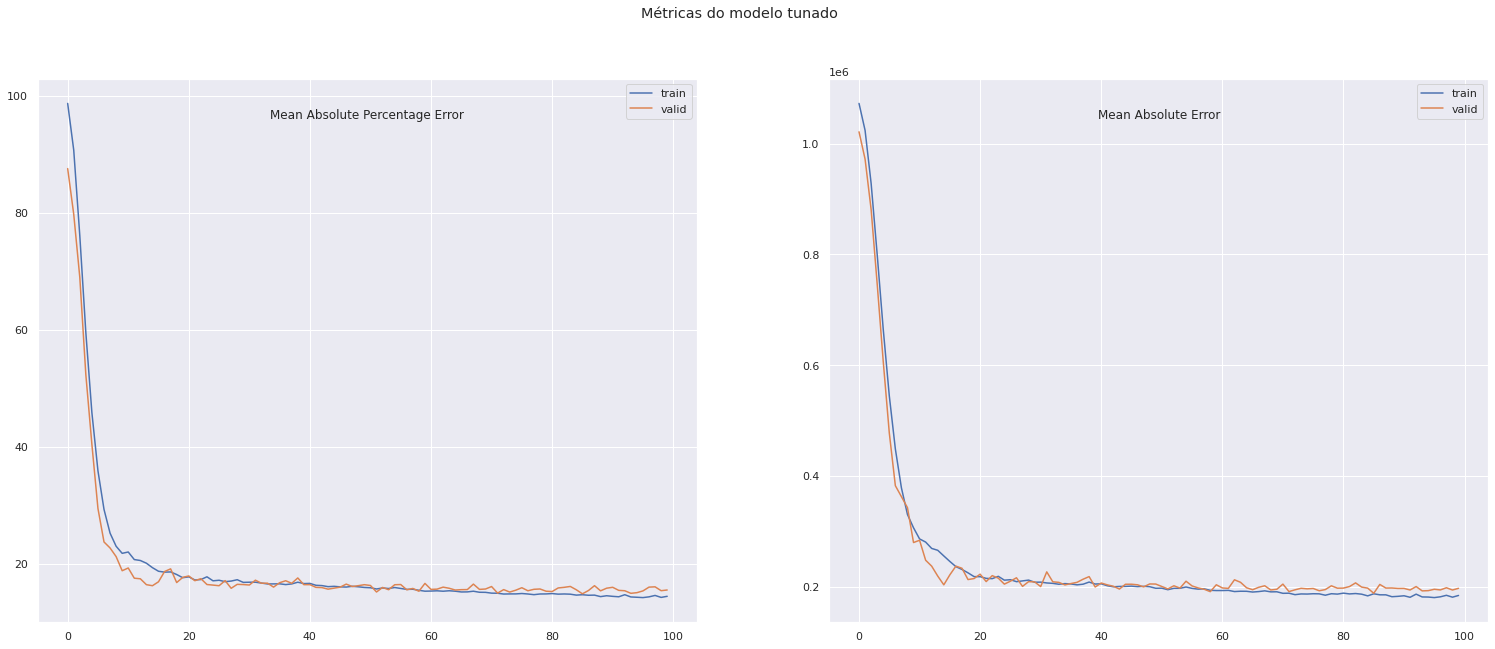

In [58]:
title_tuned = 'Métricas do modelo tunado'
plotHistory(history_tuned, title_tuned)

## Analisando os resultados

In [59]:
print("First Tiny Model:")
mape, mae = model_first.evaluate(x=test_x, y=test_y, batch_size=32, verbose=0)
print('Mean Absolute Percentage Error = {:.3f} \nMean Absolute Error = {:.3f}'.format(mape, mae))

First Tiny Model:
Mean Absolute Percentage Error = 100.000 
Mean Absolute Error = 1011479.188


In [60]:
print("Large Model:")
mape, mae = model_large.evaluate(x=test_x, y=test_y, batch_size=32, verbose=0)
print('Mean Absolute Percentage Error = {:.3f} \nMean Absolute Error = {:.3f}'.format(mape, mae))

Large Model:
Mean Absolute Percentage Error = 16.642 
Mean Absolute Error = 176527.297


In [61]:
print("Tuned Model:")
mape, mae = model_tuned.evaluate(x=test_x, y=test_y, batch_size=32, verbose=0)
print('Mean Absolute Percentage Error = {:.3f} \nMean Absolute Error = {:.3f}'.format(mape, mae))

Tuned Model:
Mean Absolute Percentage Error = 15.520 
Mean Absolute Error = 165066.469


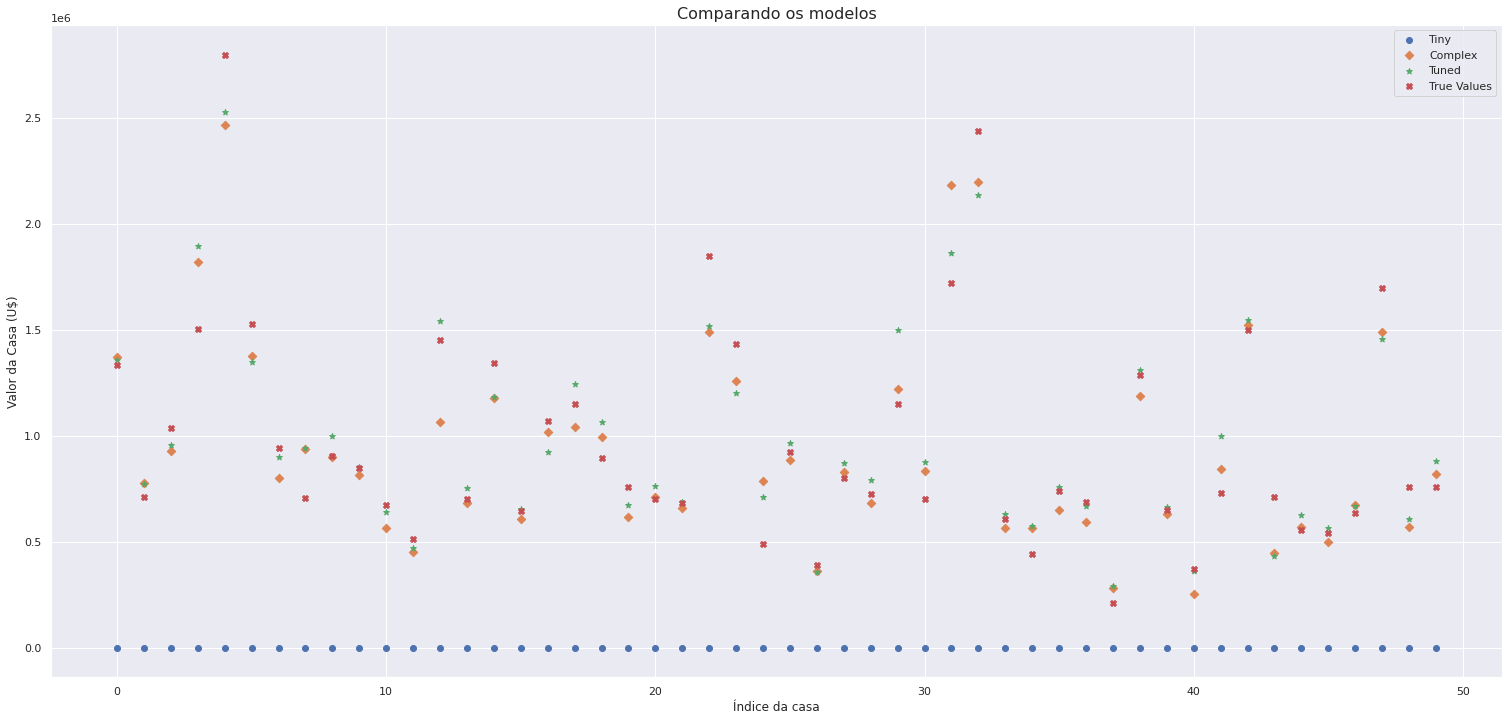

In [76]:
predictions_tiny = model_first.predict(test_x)
predictions_large = model_large.predict(test_x)
predictions_tuned = model_tuned.predict(test_x)

x_values = list(range(len(test_y[:50])))

plt.figure(figsize=(26,12))
plt.scatter(x_values, predictions_tiny[:50], label="Tiny")
plt.scatter(x_values, predictions_large[:50], marker="D",label="Complex")
plt.scatter(x_values, predictions_tuned[:50], marker="*",label="Tuned")
plt.scatter(x_values, test_y[:50], marker="X",label="True Values")
plt.legend(loc="best")
plt.title("Comparando os modelos", fontsize=16)
plt.xlabel("Índice da casa")
plt.ylabel("Valor da Casa (U$)")
plt.savefig("/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/Comparando_modelos")
plt.show()